<ipython-input-334-7e5a2e9d84eb>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df_minus['angle'] = y_df_minus.angle * -1


45.313839598916566 0.028637992457410586


,level,x,y,angle,r,ml,effective_strain,hardening_strain_bar
18,18.0,16.000000,85.491069,58.188359,0.000569,1.939716,0.045,0.711505
19,18.0,17.000000,85.482828,55.439398,0.000588,1.940013,0.045,0.736074
20,18.0,18.000000,85.518452,52.780157,0.000606,1.959852,0.045,0.753587
21,18.0,19.000000,85.597656,50.199016,0.000625,1.958152,0.045,0.762846
22,18.0,20.000000,85.719052,47.688288,0.000644,1.955642,0.045,0.766342
...,...,...,...,...,...,...,...,...
320,22.0,12.000000,101.324893,-14.841079,0.000172,2.156264,0.050,0.575549
321,22.0,11.000000,101.615882,-21.997261,0.000144,2.142680,0.050,0.624584
322,22.0,10.000000,101.841098,-31.537407,0.000117,2.147008,0.050,0.695933
323,22.0,9.027351,102.000000,-44.610886,0.000095,2.150084,0.050,0.764590


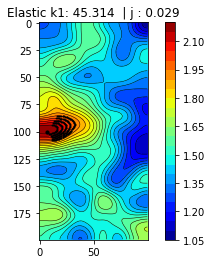

In [334]:
import DIC.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fracture

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000

# Img parameter
set_angle = 60
down_level, up_level = 18,22
contour_level = 23
ratio = 2/60
left, right, up_down = 0,100,100


path = r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC'
save_path =r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC/Output'
image = dic.load_file(path)
strain_data = np.array(pd.read_csv(path+'/effective_strain_ml_6.csv', encoding='CP949', delimiter=' ',header=None))
strain_hardening = np.array(pd.read_csv(path+'/HRR.csv', delim_whitespace=True))
eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))


crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x


i = 0 ##ref
j = 1##cur

cur = list(image.keys())[j]

src_reference = image['ff0870'][:,:,1][crack_tip[i][0]-up_down:crack_tip[i][0]+up_down,crack_tip[i][1]-left:crack_tip[i][1]+right]
src_current = image[cur][:,:,1][crack_tip[j][0]-up_down:crack_tip[j][0]+up_down,crack_tip[j][1]-left:crack_tip[j][1]+right]

dst = cv2.subtract(src_current,src_reference)
dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
gas = cv2.GaussianBlur(dst,(0,0),10)
gas[270:272,200:260] = 0


plt.imshow(src_current, cmap='gray')
# plt.axis('off')
csf = plt.contourf(gas, contour_level, cmap = 'jet')
CS = plt.contour(gas, contour_level, colors='black', linewidths = 0.5)

plt.colorbar(csf)
# plt.text( 210,285, '2mm', fontsize=9, fontweight='bold')

# max_crack_tip = [left,up_down]
max_crack_tip = [np.argmax(gas)%(left+right), up_down]
# max_crack_tip = [np.argmax(gas)%(left+right), np.argmax(gas)//(left+right)]#x,y
plt.scatter(max_crack_tip[0],max_crack_tip[1], color= 'black', s=10)

x = []
y = []
level_list = []

for level in range(down_level,up_level+1):
    x_num = CS.allsegs[level][0][:,0]
    y_num = CS.allsegs[level][0][:,1]
    x = np.append(x, x_num)
    y = np.append(y, y_num)

    for _ in range(len(x_num)):
        level_list = np.append(level_list,level)


vector_1 = [1,0]
vector_2 = [x-max_crack_tip[0], y-max_crack_tip[1]]
dot_product = np.dot(vector_1 / np.linalg.norm(vector_1), vector_2 / np.linalg.norm(vector_2,axis=0))
angle = np.rad2deg(np.arccos(dot_product))

df = pd.DataFrame({'level':level_list, 'x': x, 'y': y, 'angle' : angle})
x_df = df['x'] - max_crack_tip[0] > 0
df = df[x_df]
y_df_minus = df[df['y'] - max_crack_tip[1] > 0]
y_df_minus['angle'] = y_df_minus.angle * -1
y_df_plus = df[df['y'] - max_crack_tip[1] <= 0]
df = y_df_plus.append(y_df_minus)
df = df[df['angle']<=set_angle]
df = df[df['angle']>=set_angle*-1]
df['r'] = np.sqrt(np.power(df['x']- max_crack_tip[0],2)+np.power(df['y']- max_crack_tip[1],2)) * ratio *0.001

hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []



for y,x,theta in np.array(df[['y','x','angle']]):
    current_ml = gas[np.round(y).astype(int),np.round(x).astype(int)]
    ml = np.append(ml, current_ml)
    effective_strain = np.append(effective_strain, strain_data[find_nearest(strain_data[:,1], current_ml),0])
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])


df['ml'] = ml
df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list

plastic_k = np.power(df.effective_strain/2 * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus
elastic_k1 = np.sqrt((j_integral * youngs_modulus))

plt.scatter(df['x'],df['y'],color='black',s=0.8)
plt.title('Elastic k1: ' +  str(np.round(elastic_k1,3)) + '  | j : ' + str(np.round(j_integral,3)))
plt.savefig(save_path+'./%d.png'%j,dpi=300, bbox_inches='tight')

print(elastic_k1,j_integral)

df




In [338]:
np.sqrt(0.29*youngs_modulus)

29.151130338290486

In [ ]:
717